In [ ]:
# Persistence:  Persistence means saving data permanently so it is not lost when a program stops or the system restarts.
# Persistence is the ability of data to survive beyond program execution.
# Examples:
# Database (MySQL, PostgreSQL) ✅
# Files (TXT, JSON) ✅
# Variables in RAM ❌ (not persistent)

In [ ]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver
from langchain_groq import ChatGroq

In [ ]:
# InMemorySaver is a LangGraph checkpointer that stores graph state temporarily in RAM and loses all data when the program stops.
# from langgraph.checkpoint.memory import InMemorySaver

# checkpointer = InMemorySaver()
# graph = builder.compile(checkpointer=checkpointer)
# ✅ Advantages
# ⚡ Very fast (RAM-based)
# 🧪 Great for testing & development
# 🧩 Easy to use (no setup)
# 🔍 Helpful for debugging
# ❌ Disadvantages
# ❌ Not persistent (data lost on restart)
# ❌ Not suitable for production
# ❌ Cannot recover past sessions
# ❌ Limited by memory

# InMemorySaver stores LangGraph state in memory temporarily, offering fast checkpointing but no persistence.

<!-- InMemorySaver is a LangGraph checkpointer that stores graph state temporarily in RAM and loses all data when the program stops. -->

In [4]:
load_dotenv()

True

In [5]:
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.3
)

In [6]:
class JokeState(TypedDict):
    topic : str
    joke : str
    explaination : str

In [7]:
def generate_joke(state : JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content
    return {'joke':response}

In [8]:
def generate_explaination(state : JokeState):
    prompt = f'write an explaination for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content
    return {'explaination':response}

In [10]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke',generate_joke)
graph.add_node('generate_explaination',generate_explaination)

graph.add_edge(START,'generate_joke')
graph.add_edge('generate_joke','generate_explaination')
graph.add_edge('generate_explaination',END)

saver = InMemorySaver()

workflow = graph.compile(checkpointer = saver)

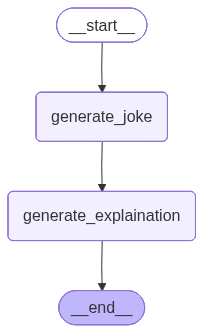

In [11]:
workflow

In [ ]:
# The config with thread_id is used to identify and separate execution threads (sessions) so LangGraph can:
# Maintain conversation / state continuity
# Store and retrieve the correct checkpoint
# Resume the right graph state

# config1 = {"configurable": {"thread_id": "1"}}
# workflow.invoke({'topic': 'technology'}, config=config1)

In [12]:
config1 = {"configurable": {"thread_id": "1"}}
workflow.invoke({'topic':'technology'},config=config1)

{'topic': 'technology',
 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.',
 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls or failed connections). \n\nThe phrase "hang-ups" can refer to emotional issues or phobias, but in the context of a smartphone, it means issues with phone calls or internet connections. The joke is funny because it takes the common phrase and applies it to a smartphone, creating a clever and unexpected pun.\n\nThe second part of the joke, "struggling to connect with others," has a double meaning. On one hand, it\'s a common phrase associated with social anxiety or difficulties in forming relationships. On the other hand, it\'s also a literal description of a smartphone\'s purpose: to connect people through calls, texts, and social me

In [ ]:
# config1 = {"configurable": {"thread_id": "1"}}
# thread_id = "1" is the unique identifier
# LangGraph’s checkpointer (like InMemorySaver) uses this as a key
# So:
# workflow.invoke({'topic': 'AI'}, config=config1)
# workflow.invoke({'topic': 'ML'}, config=config1)
# ✔ Same thread_id
# ✔ Same stored state
# ✔ Conversation continues

# When does a new thread start?
# Only when thread_id changes:
# config2 = {"configurable": {"thread_id": "2"}}
# workflow.invoke({'topic': 'AI'}, config=config2)
# ✔ Different thread_id
# ✔ New state
# ✔ New conversation

In [13]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls or failed connections). \n\nThe phrase "hang-ups" can refer to emotional issues or phobias, but in the context of a smartphone, it means issues with phone calls or internet connections. The joke is funny because it takes the common phrase and applies it to a smartphone, creating a clever and unexpected pun.\n\nThe second part of the joke, "struggling to connect with others," has a double meaning. On one hand, it\'s a common phrase associated with social anxiety or difficulties in forming relationships. On the other hand, it\'s also a literal description of a smartphone\'s purpose: to connect people through calls, t

In [14]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls or failed connections). \n\nThe phrase "hang-ups" can refer to emotional issues or phobias, but in the context of a smartphone, it means issues with phone calls or internet connections. The joke is funny because it takes the common phrase and applies it to a smartphone, creating a clever and unexpected pun.\n\nThe second part of the joke, "struggling to connect with others," has a double meaning. On one hand, it\'s a common phrase associated with social anxiety or difficulties in forming relationships. On the other hand, it\'s also a literal description of a smartphone\'s purpose: to connect people through calls, 

In [15]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls or failed connections). \n\nThe phrase "hang-ups" can refer to emotional issues or phobias, but in the context of a smartphone, it means issues with phone calls or internet connections. The joke is funny because it takes the common phrase and applies it to a smartphone, creating a clever and unexpected pun.\n\nThe second part of the joke, "struggling to connect with others," has a double meaning. On one hand, it\'s a common phrase associated with social anxiety or difficulties in forming relationships. On the other hand, it\'s also a literal description of a smartphone\'s purpose: to connect people through calls, t

In [16]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls or failed connections). \n\nThe phrase "hang-ups" can refer to emotional issues or phobias, but in the context of a smartphone, it means issues with phone calls or internet connections. The joke is funny because it takes the common phrase and applies it to a smartphone, creating a clever and unexpected pun.\n\nThe second part of the joke, "struggling to connect with others," has a double meaning. On one hand, it\'s a common phrase associated with social anxiety or difficulties in forming relationships. On the other hand, it\'s also a literal description of a smartphone\'s purpose: to connect people through calls, 

In [17]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f06cc6e-7232-6cb1-8000-f71609e6cec5", "checkpoint_ns": ""}}, {'topic':'samosa'})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f1068f0-0ae9-6b57-8000-e69567870bc5'}}

In [18]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f1068f0-0ae9-6b57-8000-e69567870bc5'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2026-02-10T14:44:28.672904+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06cc6e-7232-6cb1-8000-f71609e6cec5'}}, tasks=(PregelTask(id='7a0e1705-d07c-98df-da76-cbf32ea127d3', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls o

In [19]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f1068f0-0ae9-6b57-8000-e69567870bc5'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2026-02-10T14:44:28.672904+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06cc6e-7232-6cb1-8000-f71609e6cec5'}}, tasks=(PregelTask(id='7a0e1705-d07c-98df-da76-cbf32ea127d3', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'technology', 'joke': 'Why did the smartphone go to therapy?\n\nBecause it had a lot of hang-ups and was struggling to connect with others.', 'explaination': 'This joke is a play on words, combining a common phrase associated with mental health (having "hang-ups") with the technical features of a smartphone (having hang-ups, as in dropped calls o

Fault Tolerance:
Fault tolerance in persistence means:
The ability of a system to keep data safe and recover it correctly even when failures occur (crashes, power loss, network issues).
❌ App crashes
❌ Server restarts
❌ Network fails
👉 Your persisted data is NOT lost and can be recovered.

In [20]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
import time

In [21]:
class crashstate(TypedDict):
    input : str
    step1 : str
    step2 : str

In [22]:
def step_1(state : crashstate) -> crashstate:
    print("Executing step 1")
    return {"step1": "completed", "input": state["input"]}

In [23]:
def step_2(state : crashstate) -> crashstate:
     print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
     time.sleep(1000) 
     return {"step2": "done"}

In [24]:
def step_3(state: crashstate) -> crashstate:
    print("✅ Step 3 executed")
    return {"done": True}

In [29]:
builder = StateGraph(crashstate)
builder.add_node("step1", step_1)
builder.add_node("step2", step_2)
builder.add_node("step3", step_3)

# use the same node names as added above
builder.set_entry_point("step1")
builder.add_edge("step1", "step2")
builder.add_edge("step2", "step3")
builder.add_edge("step3", END)

saver = InMemorySaver()
# compile expects a 'checkpointer' kwarg, not 'saver'
graph = builder.compile(checkpointer=saver)

In [ ]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
Executing step 1
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)


In [ ]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)

In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

This code demonstrates how LangGraph uses checkpointing with InMemorySaver and thread_id to resume execution from the last successful step after a crash.